In [1]:
# Step 1: Import Required Libraries and Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
from scipy.io import loadmat
from scipy import signal, stats
from scipy.fft import fft, fftfreq
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Check for optional libraries
try:
    import librosa
    LIBROSA_AVAILABLE = True
    print("Librosa available for AST features")
except ImportError:
    LIBROSA_AVAILABLE = False
    print("Librosa not available - AST features will be limited")

try:
    import pywt
    WAVELET_AVAILABLE = True
    print("PyWavelets available for wavelet features")
except ImportError:
    WAVELET_AVAILABLE = False
    print("PyWavelets not available - some features will be limited")

# Setup paths and configuration
BASE_PATH = Path("E:\\College\\Sem 5\\Project\\DDMM")
DATASET_PATH = BASE_PATH / "Codes\\Dataset\\BearingType_DeepGrooveBall"
print(f"\nDataset path: {DATASET_PATH}")
print(f"Dataset exists: {DATASET_PATH.exists()}")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

print("\n Libraries imported and setup complete!")

Librosa available for AST features
PyWavelets available for wavelet features

Dataset path: E:\College\Sem 5\Project\DDMM\Codes\Dataset\BearingType_DeepGrooveBall
Dataset exists: True
TensorFlow version: 2.18.1
GPU available: False

 Libraries imported and setup complete!


In [2]:
# Step 2: Dataset Exploration and Configuration

# Define fault classes mapping (32 classes total)
FAULT_CLASSES = {
    'H_B': 0, 'H_H': 1, 'H_IR': 2, 'H_OR': 3,      # Healthy conditions
    'L_B': 4, 'L_H': 5, 'L_IR': 6, 'L_OR': 7,      # Light faults
    'M1_B': 8, 'M1_H': 9, 'M1_IR': 10, 'M1_OR': 11,   # Medium faults 1
    'M2_B': 12, 'M2_H': 13, 'M2_IR': 14, 'M2_OR': 15, # Medium faults 2
    'M3_B': 16, 'M3_H': 17, 'M3_IR': 18, 'M3_OR': 19, # Medium faults 3
    'U1_B': 20, 'U1_H': 21, 'U1_IR': 22, 'U1_OR': 23, # Unknown faults 1
    'U2_B': 24, 'U2_H': 25, 'U2_IR': 26, 'U2_OR': 27, # Unknown faults 2
    'U3_B': 28, 'U3_H': 29, 'U3_IR': 30, 'U3_OR': 31  # Unknown faults 3
}

# Bearing parameters for physics-based features
BEARING_PARAMS = {
    6204: {  # Bearing type 6204
        'inner_diameter': 20,      # mm
        'outer_diameter': 47,      # mm
        'pitch_diameter': 33.5,    # mm
        'ball_diameter': 7.5,      # mm
        'num_balls': 8,            # number of rolling elements
        'contact_angle': 0         # degrees
    }
}

# Dataset configuration
SAMPLING_RATES = [16000, 8000]  # Hz
ROTATING_SPEEDS = [600, 800, 1000, 1200, 1400, 1600]  # RPM

print("Dataset Configuration:")
print(f"Number of fault classes: {len(FAULT_CLASSES)}")
print(f"Sampling rates: {SAMPLING_RATES}")
print(f"Rotating speeds: {ROTATING_SPEEDS}")
print(f"Expected total files: {len(SAMPLING_RATES)} x {len(ROTATING_SPEEDS)} x {len(FAULT_CLASSES)} = {len(SAMPLING_RATES) * len(ROTATING_SPEEDS) * len(FAULT_CLASSES)}")

# Explore dataset structure
print("\nExploring dataset structure...")
if DATASET_PATH.exists():
    sampling_dirs = list(DATASET_PATH.glob("SamplingRate_*"))
    print(f"Found {len(sampling_dirs)} sampling rate directories:")
    
    total_files = 0
    for sample_dir in sampling_dirs:
        speed_dirs = list(sample_dir.glob("RotatingSpeed_*"))
        print(f"  {sample_dir.name}: {len(speed_dirs)} speed directories")
        
        for speed_dir in speed_dirs:
            mat_files = list(speed_dir.glob("*.mat"))
            total_files += len(mat_files)
            if len(speed_dirs) <= 3:  # Show details for first few
                print(f"    {speed_dir.name}: {len(mat_files)} files")
    
    print(f"\nTotal .mat files found: {total_files}")
else:
    print("ERROR: Dataset path does not exist!")
    print(f"Please check: {DATASET_PATH}")
print("\nDataset exploration complete!")

Dataset Configuration:
Number of fault classes: 32
Sampling rates: [16000, 8000]
Rotating speeds: [600, 800, 1000, 1200, 1400, 1600]
Expected total files: 2 x 6 x 32 = 384

Exploring dataset structure...
Found 2 sampling rate directories:
  SamplingRate_16000: 6 speed directories
  SamplingRate_8000: 6 speed directories

Total .mat files found: 384

Dataset exploration complete!


Loading a sample signal to inspect the data...
Loading sample file: H_B_16_6204_600.mat
Keys in .mat file:
  Data: <class 'numpy.ndarray'> - shape: (1280000, 1)
  STFTFreq: <class 'numpy.ndarray'> - shape: (128, 1)
  STFTTime: <class 'numpy.ndarray'> - shape: (1, 128)
  Spectrogram: <class 'numpy.ndarray'> - shape: (78, 128, 128)
Signal found in key: 'Data'
Raw signal shape: (1280000, 1)
Raw signal size: 1280000
Flattened signal length: 1280000
Signal value range: [-0.582827, 0.633123]
Signal mean: -0.000001
Signal std: 0.026756
Metadata - Fault class: H_B, Sampling rate: 16000Hz, RPM: 600

RAW SIGNAL ANALYSIS
Preprocessing signal: length=1280000, fs=16000Hz
After DC removal - mean: -0.00000000
Removing 561 outliers (0.04%)
Applied high-pass filter at 5Hz
Normalized signal - std: 1.000000
Final processed signal stats:
  Length: 1280000
  Range: [-5.064831, 5.073421]
  Mean: -0.00014129
  Std: 1.000000


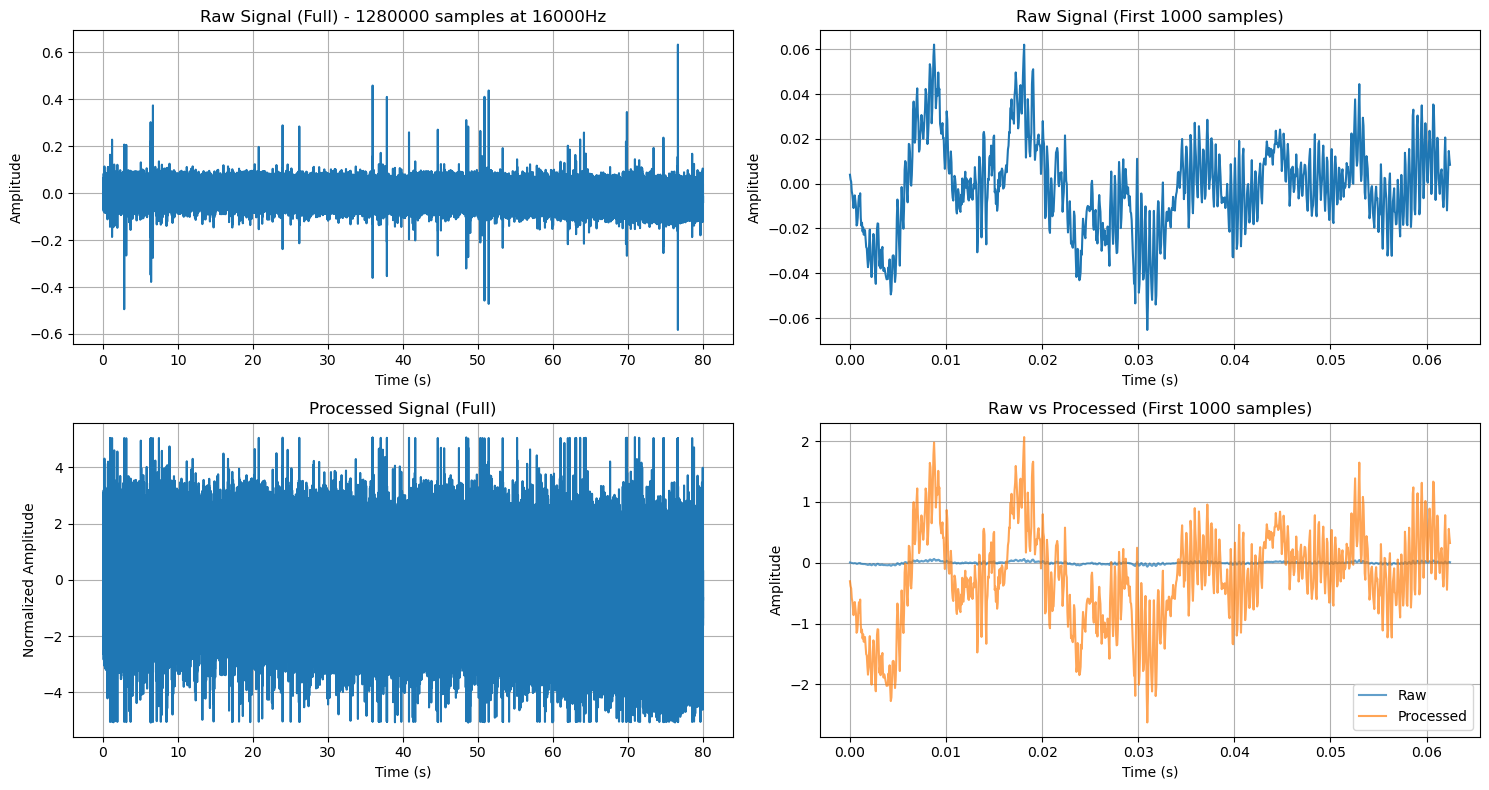


Signal preprocessing verified successfully!


In [ ]:
# Step 3: Signal Inspection and Preprocessing Pipeline

def load_sample_signal():
    """Load and visualize a sample signal to understand the data structure"""
    print("Loading a sample signal to inspect the data...")
    
    # Get first available .mat file
    sample_file = None
    for sampling_rate in SAMPLING_RATES:
        sampling_dir = DATASET_PATH / f"SamplingRate_{sampling_rate}"
        if sampling_dir.exists():
            for rpm in ROTATING_SPEEDS:
                speed_dir = sampling_dir / f"RotatingSpeed_{rpm}"
                if speed_dir.exists():
                    mat_files = list(speed_dir.glob("*.mat"))
                    if mat_files:
                        sample_file = mat_files[0]
                        break
            if sample_file:
                break
    
    if sample_file is None:
        print("No .mat files found!")
        return None, None, None
    
    print(f"Loading sample file: {sample_file.name}")
    
    # Load the .mat file
    mat_data = loadmat(str(sample_file))
    
    print("Keys in .mat file:")
    for key, value in mat_data.items():
        if not key.startswith('__'):
            print(f"  {key}: {type(value)} - shape: {getattr(value, 'shape', 'N/A')}")
    
    # Find the signal data (largest array)
    signal_data = None
    signal_key = None
    max_size = 0
    
    for key, value in mat_data.items():
        if not key.startswith('__') and isinstance(value, np.ndarray):
            if value.size > max_size:
                max_size = value.size
                signal_data = value
                signal_key = key
    
    if signal_data is None:
        print("No signal data found!")
        return None, None, None
    
    print(f"Signal found in key: '{signal_key}'")
    print(f"Raw signal shape: {signal_data.shape}")
    print(f"Raw signal size: {signal_data.size}")
    
    # Flatten the signal
    signal = signal_data.flatten()
    print(f"Flattened signal length: {len(signal)}")
    print(f"Signal value range: [{np.min(signal):.6f}, {np.max(signal):.6f}]")
    print(f"Signal mean: {np.mean(signal):.6f}")
    print(f"Signal std: {np.std(signal):.6f}")
    
    # Extract metadata from filename
    filename = sample_file.stem
    parts = filename.split('_')
    fault_class = f"{parts[0]}_{parts[1]}"
    sampling_rate = int(parts[2]) * 1000 if len(parts) > 2 else 16000
    rpm = int(parts[-1]) if len(parts) > 4 else 1000
    
    print(f"Metadata - Fault class: {fault_class}, Sampling rate: {sampling_rate}Hz, RPM: {rpm}")
    
    return signal, sampling_rate, rpm

def preprocess_signal(signal, fs):
    """Apply comprehensive preprocessing to raw vibration signal"""
    print(f"Preprocessing signal: length={len(signal)}, fs={fs}Hz")
    
    # Step 1: Remove DC component (mean removal)
    #signal_processed = signal - np.mean(signal)
    #print(f"After DC removal - mean: {np.mean(signal_processed):.8f}")
    
    # Step 2: Outlier removal (remove extreme values beyond 5 standard deviations)
    std_threshold = 5
    mean_val = np.mean(signal_processed)
    std_val = np.std(signal_processed)
    outlier_mask = np.abs(signal_processed - mean_val) < (std_threshold * std_val)
    
    if np.sum(~outlier_mask) > 0:
        print(f"Removing {np.sum(~outlier_mask)} outliers ({100*np.sum(~outlier_mask)/len(signal):.2f}%)")
        # Replace outliers with clipped values
        signal_processed = np.clip(signal_processed, 
                                 mean_val - std_threshold * std_val,
                                 mean_val + std_threshold * std_val)
    
    # Step 3: High-pass filtering to remove very low frequencies
    if len(signal_processed) > 100:
        from scipy.signal import butter, filtfilt
        try:
            nyquist = fs / 2
            low_cutoff = 5  # Hz - remove frequencies below 5Hz
            if low_cutoff < nyquist:
                b, a = butter(3, low_cutoff / nyquist, btype='high')
                signal_processed = filtfilt(b, a, signal_processed)
                print(f"Applied high-pass filter at {low_cutoff}Hz")
        except Exception as e:
            print(f"Filtering failed: {e}")
    
    # Step 4: Normalization (optional - can help with feature stability)
    # Normalize to unit variance while preserving mean=0
    if np.std(signal_processed) > 0:
        signal_processed = signal_processed / np.std(signal_processed)
        print(f"Normalized signal - std: {np.std(signal_processed):.6f}")
    
    print(f"Final processed signal stats:")
    print(f"  Length: {len(signal_processed)}")
    print(f"  Range: [{np.min(signal_processed):.6f}, {np.max(signal_processed):.6f}]")
    print(f"  Mean: {np.mean(signal_processed):.8f}")
    print(f"  Std: {np.std(signal_processed):.6f}")
    
    return signal_processed

# Load and inspect a sample signal
sample_signal, sample_fs, sample_rpm = load_sample_signal()

if sample_signal is not None:
    print(f"\n" + "="*50)
    print("RAW SIGNAL ANALYSIS")
    print("="*50)
    
    # Plot the raw signal
    plt.figure(figsize=(15, 8))
    
    # Plot 1: Full signal
    plt.subplot(2, 2, 1)
    time = np.arange(len(sample_signal)) / sample_fs
    plt.plot(time, sample_signal)
    plt.title(f'Raw Signal (Full) - {len(sample_signal)} samples at {sample_fs}Hz')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # Plot 2: First 1000 samples
    plt.subplot(2, 2, 2)
    n_samples = min(1000, len(sample_signal))
    time_short = np.arange(n_samples) / sample_fs
    plt.plot(time_short, sample_signal[:n_samples])
    plt.title(f'Raw Signal (First {n_samples} samples)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # Preprocess the signal
    processed_signal = preprocess_signal(sample_signal, sample_fs)
    
    # Plot 3: Processed signal
    plt.subplot(2, 2, 3)
    plt.plot(time, processed_signal)
    plt.title('Processed Signal (Full)')
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Amplitude')
    plt.grid(True)
    
    # Plot 4: Comparison (first 1000 samples)
    plt.subplot(2, 2, 4)
    plt.plot(time_short, sample_signal[:n_samples], label='Raw', alpha=0.7)
    plt.plot(time_short, processed_signal[:n_samples], label='Processed', alpha=0.7)
    plt.title('Raw vs Processed (First 1000 samples)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nSignal preprocessing verified successfully!")
else:
    print("Failed to load sample signal!")

In [10]:
# Step 4: AST (Audio Spectrogram Transformer) Feature Extraction Functions

def extract_ast_features(signal, fs, target_length=768):
    """Extract AST-style features using librosa (if available) or fallback methods"""
    features = []
    
    try:
        if LIBROSA_AVAILABLE:
            import librosa
            
            # Resample if needed (librosa works best with 22050 Hz)
            target_sr = 22050
            if fs != target_sr and len(signal) > 1000:
                signal_resampled = librosa.resample(signal.astype(float), orig_sr=fs, target_sr=target_sr)
            else:
                signal_resampled = signal.astype(float)
                target_sr = fs
            
            # 1. Mel-frequency cepstral coefficients (MFCCs) - 13 features
            mfccs = librosa.feature.mfcc(y=signal_resampled, sr=target_sr, n_mfcc=13)
            mfcc_features = []
            for i in range(mfccs.shape[0]):
                mfcc_features.extend([
                    np.mean(mfccs[i]), np.std(mfccs[i]), 
                    np.max(mfccs[i]), np.min(mfccs[i])
                ])
            features.extend(mfcc_features)  # 13 * 4 = 52 features
            
            # 2. Mel-scale spectrogram - statistical features
            mel_spec = librosa.feature.melspectrogram(y=signal_resampled, sr=target_sr, n_mels=128)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            
            # Statistics across time for each mel band (first 64 bands)
            for i in range(min(64, mel_spec_db.shape[0])):
                features.extend([
                    np.mean(mel_spec_db[i]), np.std(mel_spec_db[i]),
                    np.max(mel_spec_db[i]), np.min(mel_spec_db[i]),
                    np.median(mel_spec_db[i])
                ])
            # 64 * 5 = 320 features
            
            # 3. Spectral features
            spectral_centroid = librosa.feature.spectral_centroid(y=signal_resampled, sr=target_sr)[0]
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=signal_resampled, sr=target_sr)[0]
            spectral_rolloff = librosa.feature.spectral_rolloff(y=signal_resampled, sr=target_sr)[0]
            zero_crossing_rate = librosa.feature.zero_crossing_rate(signal_resampled)[0]
            
            spectral_features = [
                np.mean(spectral_centroid), np.std(spectral_centroid),
                np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
                np.mean(spectral_rolloff), np.std(spectral_rolloff),
                np.mean(zero_crossing_rate), np.std(zero_crossing_rate)
            ]
            features.extend(spectral_features)  # 8 features
            
            # 4. Chroma features
            chroma = librosa.feature.chroma_stft(y=signal_resampled, sr=target_sr)
            for i in range(chroma.shape[0]):
                features.extend([
                    np.mean(chroma[i]), np.std(chroma[i]),
                    np.max(chroma[i]), np.min(chroma[i])
                ])
            # 12 * 4 = 48 features
            
            # 5. Tonnetz (harmonic network) features
            tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(signal_resampled), sr=target_sr)
            for i in range(tonnetz.shape[0]):
                features.extend([
                    np.mean(tonnetz[i]), np.std(tonnetz[i]),
                    np.max(tonnetz[i]), np.min(tonnetz[i])
                ])
            # 6 * 4 = 24 features
            
            # 6. Spectral contrast
            contrast = librosa.feature.spectral_contrast(y=signal_resampled, sr=target_sr)
            for i in range(contrast.shape[0]):
                features.extend([
                    np.mean(contrast[i]), np.std(contrast[i]),
                    np.max(contrast[i]), np.min(contrast[i])
                ])
            # 7 * 4 = 28 features
            
            # Total so far: 52 + 320 + 8 + 48 + 24 + 28 = 480 features
            
            # 7. Additional features to reach target_length (768)
            remaining_features = target_length - len(features)
            if remaining_features > 0:
                # Use additional mel-frequency features from remaining bands
                n_additional_mels = min(remaining_features // 5, 128 - 64)
                for i in range(64, min(64 + n_additional_mels, mel_spec_db.shape[0])):
                    features.extend([
                        np.mean(mel_spec_db[i]), np.std(mel_spec_db[i]),
                        np.max(mel_spec_db[i]), np.min(mel_spec_db[i]),
                        np.median(mel_spec_db[i])
                    ])
                
                # Pad with zeros if still needed
                if len(features) < target_length:
                    features.extend([0.0] * (target_length - len(features)))
        
        else:
            # Fallback AST features using scipy
            print("Using fallback AST features (librosa not available)")
            features = extract_ast_features_fallback(signal, fs, target_length)
            
        # Ensure exact target length
        features = features[:target_length]
        
    except Exception as e:
        print(f"Error in AST feature extraction: {e}")
        features = [0.0] * target_length
    
    return np.array(features)

def extract_ast_features_fallback(signal, fs, target_length=768):
    """Fallback AST features when librosa is not available"""
    features = []
    
    # 1. FFT-based spectral analysis
    fft_vals = fft(signal)
    freqs = fftfreq(len(signal), 1/fs)
    fft_magnitude = np.abs(fft_vals)
    
    # Positive frequencies only
    positive_freq_idx = freqs > 0
    fft_magnitude = fft_magnitude[positive_freq_idx]
    positive_freqs = freqs[positive_freq_idx]
    
    # 2. Create mel-like frequency bands (logarithmic spacing)
    max_freq = fs / 2
    num_bands = 128
    band_edges = np.logspace(np.log10(1), np.log10(max_freq), num_bands + 1)
    
    # Extract power and statistics in each band
    for i in range(num_bands):
        band_mask = (positive_freqs >= band_edges[i]) & (positive_freqs < band_edges[i + 1])
        if np.any(band_mask):
            band_power = np.sum(fft_magnitude[band_mask]**2)
            band_mean_freq = np.mean(positive_freqs[band_mask])
            band_std_power = np.std(fft_magnitude[band_mask])
            features.extend([band_power, band_mean_freq, band_std_power])
        else:
            features.extend([0.0, 0.0, 0.0])
    
    # 3. Add spectral features
    psd = fft_magnitude**2
    total_power = np.sum(psd)
    
    if total_power > 0:
        spectral_centroid = np.sum(positive_freqs * psd) / total_power
        spectral_spread = np.sqrt(np.sum(((positive_freqs - spectral_centroid)**2) * psd) / total_power)
    else:
        spectral_centroid = 0
        spectral_spread = 0
    
    features.extend([
        spectral_centroid, spectral_spread,
        np.percentile(positive_freqs, 85),  # rolloff
        stats.gmean(psd + 1e-10) / np.mean(psd) if np.mean(psd) > 0 else 0  # flatness
    ])
    
    # 4. Add time-domain sliding window statistics to reach target length
    remaining = target_length - len(features)
    if remaining > 0:
        window_size = max(len(signal) // (remaining // 4), 100)
        if window_size > 0:
            for i in range(0, len(signal) - window_size, window_size):
                if len(features) >= target_length:
                    break
                window = signal[i:i + window_size]
                features.extend([
                    np.mean(window), np.std(window),
                    np.max(window), np.min(window)
                ])
    
    # Pad or truncate to exact length
    if len(features) < target_length:
        features.extend([0.0] * (target_length - len(features)))
    features = features[:target_length]
    
    return features


In [11]:
# Step 5: AST Feature Extraction Pipeline for Preprocessed Signals

def extract_ast_from_same_signals():
    """Extract AST features from the same preprocessed signals used for manual features"""
    print("Starting AST feature extraction from the same preprocessed signals...")
    print("This uses the same signal loading and preprocessing as manual features")
    
    ast_features_list = []
    processed_files = 0
    failed_files = 0
    
    # Process each sampling rate and speed (same order as manual features)
    for sampling_rate in SAMPLING_RATES:
        sampling_dir = DATASET_PATH / f"SamplingRate_{sampling_rate}"
        
        if not sampling_dir.exists():
            continue
            
        for rpm in ROTATING_SPEEDS:
            speed_dir = sampling_dir / f"RotatingSpeed_{rpm}"
            
            if not speed_dir.exists():
                continue
                
            mat_files = list(speed_dir.glob("*.mat"))
            
            print(f"Processing AST features for {len(mat_files)} files from {speed_dir.name} at {sampling_rate}Hz, {rpm}RPM")
            
            for mat_file in mat_files:
                try:
                    # Parse filename (same logic as manual features)
                    filename = mat_file.stem
                    parts = filename.split('_')
                    if len(parts) < 2:
                        failed_files += 1
                        continue
                        
                    fault_class_key = f"{parts[0]}_{parts[1]}"
                    
                    if fault_class_key not in FAULT_CLASSES:
                        failed_files += 1
                        continue
                    
                    # Load .mat file (same logic as manual features)
                    mat_data = loadmat(str(mat_file))
                    
                    # Find signal data
                    signal_data = None
                    if 'Data' in mat_data:
                        signal_data = mat_data['Data']
                    else:
                        max_size = 0
                        for key, value in mat_data.items():
                            if not key.startswith('__') and isinstance(value, np.ndarray):
                                if value.size > max_size:
                                    max_size = value.size
                                    signal_data = value
                    
                    if signal_data is None or signal_data.size == 0:
                        failed_files += 1
                        continue
                    
                    # Apply SAME preprocessing as manual features
                    raw_signal = signal_data.flatten()
                    
                    if len(raw_signal) < 1000:
                        failed_files += 1
                        continue
                    
                    # Apply exact same preprocessing
                    processed_signal = preprocess_signal(raw_signal, sampling_rate)
                    
                    # Extract AST features from preprocessed signal
                    ast_features_array = extract_ast_features(processed_signal, sampling_rate, target_length=768)
                    
                    if len(ast_features_array) != 768:
                        print(f"AST feature extraction error: got {len(ast_features_array)} features instead of 768")
                        failed_files += 1
                        continue
                    
                    # Check for invalid values
                    if np.any(~np.isfinite(ast_features_array)):
                        print(f"Invalid AST feature values in {mat_file.name}")
                        # Replace invalid values with 0
                        ast_features_array = np.where(np.isfinite(ast_features_array), ast_features_array, 0)
                    
                    # Store results
                    ast_features_list.append(ast_features_array)
                    processed_files += 1
                    
                    if processed_files % 50 == 0:
                        print(f"AST Progress: {processed_files} processed, {failed_files} failed")
                        
                except Exception as e:
                    print(f"Error processing AST features for {mat_file.name}: {str(e)}")
                    failed_files += 1
                    continue

    print(f"\nAST Processing summary:")
    print(f"Successfully processed: {processed_files}")
    print(f"Failed: {failed_files}")

    # Convert to array
    if len(ast_features_list) > 0:
        ast_features = np.array(ast_features_list)
        
        print(f"\n AST FEATURES EXTRACTED SUCCESSFULLY!")
        print(f"AST features shape: {ast_features.shape}")
        print(f"Expected shape: (384, 768)")
        print(f"Shape verification: Features={ast_features.shape[1] == 768}, Samples={ast_features.shape[0]}")
        
        # Verify alignment with manual features
        if 'manual_features' in locals() or 'manual_features' in globals():
            manual_shape = manual_features.shape if 'manual_features' in globals() else "Not available"
            print(f"Manual features shape: {manual_shape}")
            print(f"Sample count match: {ast_features.shape[0] == manual_features.shape[0] if 'manual_features' in globals() else 'Cannot verify'}")
        
        # Show feature statistics
        print(f"\nAST Feature Statistics:")
        print(f"  Value range: [{np.min(ast_features):.6f}, {np.max(ast_features):.6f}]")
        print(f"  Features with zeros: {np.sum(ast_features == 0)}")
        print(f"  Features with inf/nan: {np.sum(~np.isfinite(ast_features))}")
        
        return ast_features
    else:
        print("\n FAILED: No AST features extracted")
        return None

# Execute AST feature extraction
print("Starting AST feature extraction pipeline...")
print("=" * 70)
ast_features = extract_ast_from_same_signals()

Starting AST feature extraction pipeline...
Starting AST feature extraction from the same preprocessed signals...
This uses the same signal loading and preprocessing as manual features
Processing AST features for 32 files from RotatingSpeed_600 at 16000Hz, 600RPM
Preprocessing signal: length=1280000, fs=16000Hz
After DC removal - mean: -0.00000000
Removing 561 outliers (0.04%)
Applied high-pass filter at 5Hz
Normalized signal - std: 1.000000
Final processed signal stats:
  Length: 1280000
  Range: [-5.064831, 5.073421]
  Mean: -0.00014129
  Std: 1.000000
Preprocessing signal: length=1280000, fs=16000Hz
After DC removal - mean: -0.00000000
Removing 32 outliers (0.00%)
Applied high-pass filter at 5Hz
Normalized signal - std: 1.000000
Final processed signal stats:
  Length: 1280000
  Range: [-5.018784, 5.622509]
  Mean: -0.00010661
  Std: 1.000000
Preprocessing signal: length=1280000, fs=16000Hz
After DC removal - mean: -0.00000000
Removing 9834 outliers (0.77%)
Applied high-pass filter a

In [12]:
print("ast_features_shape: ",ast_features.shape)

ast_features_shape:  (384, 768)


In [4]:
import numpy as np
ast_features = np.load('ast_features.npy')

In [5]:
# Step 6: Create Labels and Prepare Data for Training

def create_labels_for_ast_features():
    """Create labels that correspond to the extracted AST features"""
    print("Creating labels for AST features...")
    
    labels_list = []
    processed_files = 0
    
    # Process in same order as AST feature extraction
    for sampling_rate in SAMPLING_RATES:
        sampling_dir = DATASET_PATH / f"SamplingRate_{sampling_rate}"
        
        if not sampling_dir.exists():
            continue
            
        for rpm in ROTATING_SPEEDS:
            speed_dir = sampling_dir / f"RotatingSpeed_{rpm}"
            
            if not speed_dir.exists():
                continue
                
            mat_files = list(speed_dir.glob("*.mat"))
            
            for mat_file in mat_files:
                try:
                    # Parse filename (same logic as AST extraction)
                    filename = mat_file.stem
                    parts = filename.split('_')
                    if len(parts) < 2:
                        continue
                        
                    fault_class_key = f"{parts[0]}_{parts[1]}"
                    
                    if fault_class_key not in FAULT_CLASSES:
                        continue
                    
                    # Load and check signal (same validation as AST extraction)
                    mat_data = loadmat(str(mat_file))
                    
                    signal_data = None
                    if 'Data' in mat_data:
                        signal_data = mat_data['Data']
                    else:
                        max_size = 0
                        for key, value in mat_data.items():
                            if not key.startswith('__') and isinstance(value, np.ndarray):
                                if value.size > max_size:
                                    max_size = value.size
                                    signal_data = value
                    
                    if signal_data is None or signal_data.size == 0:
                        continue
                    
                    raw_signal = signal_data.flatten()
                    if len(raw_signal) < 1000:
                        continue
                    
                    # Store label
                    labels_list.append(FAULT_CLASSES[fault_class_key])
                    processed_files += 1
                        
                except Exception as e:
                    continue

    print(f"Created labels for {processed_files} samples")
    return np.array(labels_list)

# Create labels
ast_labels = create_labels_for_ast_features()

# Verify data alignment
print(f"AST Features shape: {ast_features.shape}")
print(f"AST Labels shape: {ast_labels.shape}")
print(f"Data alignment check: {ast_features.shape[0] == ast_labels.shape[0]}")

# Check label distribution
unique_labels, counts = np.unique(ast_labels, return_counts=True)
print(f"\nLabel distribution:")
print(f"Number of classes: {len(unique_labels)}")
print(f"Samples per class: min={np.min(counts)}, max={np.max(counts)}, mean={np.mean(counts):.1f}")

# Convert labels to categorical
num_classes = len(unique_labels)
ast_labels_categorical = to_categorical(ast_labels, num_classes=num_classes)
print(f"Categorical labels shape: {ast_labels_categorical.shape}")

Creating labels for AST features...
Created labels for 384 samples
AST Features shape: (384, 768)
AST Labels shape: (384,)
Data alignment check: True

Label distribution:
Number of classes: 32
Samples per class: min=12, max=12, mean=12.0
Categorical labels shape: (384, 32)


In [6]:
# Step 7: Data Preprocessing and Train-Test Split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Standardize the features
print("Standardizing AST features...")
scaler = StandardScaler()
ast_features_scaled = scaler.fit_transform(ast_features)

print(f"Original features - Mean: {np.mean(ast_features):.4f}, Std: {np.std(ast_features):.4f}")
print(f"Scaled features - Mean: {np.mean(ast_features_scaled):.4f}, Std: {np.std(ast_features_scaled):.4f}")

# Train/Validation/Test Split
print("\nSplitting data into train, validation, and test sets...")

# First: create test set (10%)
X_temp, X_test, y_temp, y_test = train_test_split(
    ast_features_scaled,
    ast_labels_categorical,
    test_size=0.1,
    random_state=42,
    stratify=ast_labels
)

# Second: create validation set (20% of remaining; so 0.2 * 0.9 = 0.18 ≈ 18% total)
# To get 0.7 train / 0.2 val, set val fraction to 2/9 of remaining
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=2/9,
    random_state=42,
    stratify=np.argmax(y_temp, axis=1)  # Stratify by original labels
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training labels: {y_train.shape}")
print(f"Validation labels: {y_val.shape}")
print(f"Test labels: {y_test.shape}")

# Verify class distribution in splits
train_class_counts = np.sum(y_train, axis=0)
val_class_counts = np.sum(y_val, axis=0)
test_class_counts = np.sum(y_test, axis=0)
print(f"\nTrain set - classes with samples: {np.sum(train_class_counts > 0)}")
print(f"Validation set - classes with samples: {np.sum(val_class_counts > 0)}")
print(f"Test set - classes with samples: {np.sum(test_class_counts > 0)}")

Standardizing AST features...
Original features - Mean: -12.3731, Std: 162.5259
Scaled features - Mean: -0.0000, Std: 0.9928

Splitting data into train, validation, and test sets...
Training set: (268, 768)
Validation set: (77, 768)
Test set: (39, 768)
Training labels: (268, 32)
Validation labels: (77, 32)
Test labels: (39, 32)

Train set - classes with samples: 32
Validation set - classes with samples: 32
Test set - classes with samples: 32


In [7]:
# Step 8: Create Feed Forward Neural Network with 3 Dense Layers

def create_ffnn_model(input_dim, num_classes):
    """
    Create a Feed Forward Neural Network with exactly 3 dense layers
    """
    print(f"Creating FFNN with input_dim={input_dim}, num_classes={num_classes}")
    
    # Input layer
    inputs = Input(shape=(input_dim,), name='ast_input')
    
    # First Dense Layer: 768 -> 256
    x = Dense(256, activation='relu', name='dense_1')(inputs)
    x = BatchNormalization(name='bn_1')(x)
    x = Dropout(0.3, name='dropout_1')(x)
    
    # Second Dense Layer: 256 -> 128  
    x = Dense(128, activation='relu', name='dense_2')(x)
    x = BatchNormalization(name='bn_2')(x)
    x = Dropout(0.3, name='dropout_2')(x)
    
    # Third Dense Layer: 128 -> 64
    x = Dense(64, activation='relu', name='dense_3')(x)
    x = BatchNormalization(name='bn_3')(x)
    x = Dropout(0.2, name='dropout_3')(x)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax', name='output')(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs, name='AST_FFNN_3_Layers')
    
    return model

# Create the model
ffnn_model = create_ffnn_model(
    input_dim=ast_features_scaled.shape[1],  # 768
    num_classes=num_classes
)

# Display model architecture
print("="*60)
print("FEED FORWARD NEURAL NETWORK ARCHITECTURE")
print("="*60)
ffnn_model.summary()

print(f"\nModel Details:")
print(f"Total parameters: {ffnn_model.count_params():,}")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in ffnn_model.trainable_weights]):,}")
print(f"Input shape: {ffnn_model.input_shape}")
print(f"Output shape: {ffnn_model.output_shape}")

Creating FFNN with input_dim=768, num_classes=32
FEED FORWARD NEURAL NETWORK ARCHITECTURE


Model: "AST_FFNN_3_Layers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ast_input (InputLayer)          │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 32)             │         2,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,888 (944.88 KB)

 Trainable params: 240,992 (941.38 KB)

 Non-trainable params: 896 (3.50 KB)


Model Details:
Total parameters: 241,888
Trainable parameters: 240,992
Input shape: (None, 768)
Output shape: (None, 32)


In [8]:
# Step 9: Compile and Train the FFNN Model

# Compile the model
print("Compiling the model...")
ffnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-6,
        verbose=1,
        mode='min'
    ),
    ModelCheckpoint(
        'best_ast_ffnn_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]

print("="*60)
print("STARTING TRAINING - AST FEATURES + FFNN")
print("="*60)

print(f"Training Configuration:")
print(f"  Input features: {X_train.shape[1]} (AST features)")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Test samples: {X_test.shape[0]}")
print(f"  Number of classes: {num_classes}")
print(f"  Architecture: 768 -> 256 -> 128 -> 64 -> {num_classes}")

# Start training - fix the time conflict
import time as time_module
start_time = time_module.time()

history = ffnn_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

training_time = time_module.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

# Save the final model
ffnn_model.save('ast_ffnn_final_model.h5')
print("Final model saved as 'ast_ffnn_final_model.h5'")

Compiling the model...
STARTING TRAINING - AST FEATURES + FFNN
Training Configuration:
  Input features: 768 (AST features)
  Training samples: 268
  Test samples: 39
  Number of classes: 32
  Architecture: 768 -> 256 -> 128 -> 64 -> 32
Epoch 1/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.0312 - loss: 4.2182
Epoch 1: val_accuracy improved from None to 0.10256, saving model to best_ast_ffnn_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.0485 - loss: 3.8535 - val_accuracy: 0.1026 - val_loss: 3.5334 - learning_rate: 0.0010
Epoch 2/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1250 - loss: 3.2597
Epoch 2: val_accuracy did not improve from 0.10256
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1194 - loss: 3.3065 - val_accuracy: 0.1026 - val_loss: 3.3641 - learning_rate: 0.0010
Epoch 3/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1250 - loss: 3.0099
Epoch 3: val_accuracy improved from 0.10256 to 0.12821, saving model to best_ast_ffnn_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1530 - loss: 3.0108 - val_accuracy: 0.1282 - val_loss: 3.2127 - learning_rate: 0.0010
Epoch 4/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3125 - loss: 2.6717
Epoch 4: val_accuracy did not improve from 0.12821
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2463 - loss: 2.7899 - val_accuracy: 0.0769 - val_loss: 2.9999 - learning_rate: 0.0010
Epoch 5/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1250 - loss: 3.0811
Epoch 5: val_accuracy did not improve from 0.12821
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2090 - loss: 2.6938 - val_accuracy: 0.0513 - val_loss: 2.8831 - learning_rate: 0.0010
Epoch 6/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3438 - loss: 2.3009
Epoch 6: val_accuracy improved from 0.12821 to 0.15385, saving model to best_ast_ffnn_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3097 - loss: 2.4777 - val_accuracy: 0.1538 - val_loss: 2.7434 - learning_rate: 0.0010
Epoch 7/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4062 - loss: 2.3334
Epoch 7: val_accuracy improved from 0.15385 to 0.20513, saving model to best_ast_ffnn_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3433 - loss: 2.3239 - val_accuracy: 0.2051 - val_loss: 2.5513 - learning_rate: 0.0010
Epoch 8/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4375 - loss: 1.9673
Epoch 8: val_accuracy improved from 0.20513 to 0.28205, saving model to best_ast_ffnn_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3209 - loss: 2.2034 - val_accuracy: 0.2821 - val_loss: 2.4287 - learning_rate: 0.0010
Epoch 9/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4375 - loss: 2.0967
Epoch 9: val_accuracy did not improve from 0.28205
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4179 - loss: 1.9767 - val_accuracy: 0.2821 - val_loss: 2.2618 - learning_rate: 0.0010
Epoch 10/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5312 - loss: 1.8169
Epoch 10: val_accuracy improved from 0.28205 to 0.30769, saving model to best_ast_ffnn_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4664 - loss: 1.9082 - val_accuracy: 0.3077 - val_loss: 2.1472 - learning_rate: 0.0010
Epoch 11/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4062 - loss: 1.9696
Epoch 11: val_accuracy did not improve from 0.30769
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4851 - loss: 1.8082 - val_accuracy: 0.2821 - val_loss: 2.1021 - learning_rate: 0.0010
Epoch 12/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5000 - loss: 1.7192
Epoch 12: val_accuracy did not improve from 0.30769
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4851 - loss: 1.7409 - val_accuracy: 0.2308 - val_loss: 1.8886 - learning_rate: 0.0010
Epoch 13/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4375 - loss: 1.8862
Epoch 13: val_accuracy did not improve from 0.30769
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4739 - loss: 1.7089 - val_accuracy: 0.3077 - val_loss: 1.7539 - learning_rate: 0.0010
Epoch 14/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5746 - loss: 1.4985 - val_accuracy: 0.3333 - val_loss: 1.6320 - learning_rate: 0.0010
Epoch 15/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7188 - loss: 1.3222
Epoch 15: val_accuracy improved from 0.33333 to 0.43590, saving model to best_ast_ffnn_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5746 - loss: 1.4393 - val_accuracy: 0.4359 - val_loss: 1.5696 - learning_rate: 0.0010
Epoch 16/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5312 - loss: 1.8075
Epoch 16: val_accuracy did not improve from 0.43590
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5410 - loss: 1.5675 - val_accuracy: 0.4359 - val_loss: 1.5035 - learning_rate: 0.0010
Epoch 17/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7188 - loss: 1.2456
Epoch 17: val_accuracy improved from 0.43590 to 0.51282, saving model to best_ast_ffnn_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5597 - loss: 1.4574 - val_accuracy: 0.5128 - val_loss: 1.5383 - learning_rate: 0.0010
Epoch 18/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5625 - loss: 1.3672
Epoch 18: val_accuracy improved from 0.51282 to 0.53846, saving model to best_ast_ffnn_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6157 - loss: 1.3265 - val_accuracy: 0.5385 - val_loss: 1.4507 - learning_rate: 0.0010
Epoch 19/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6562 - loss: 1.2165
Epoch 19: val_accuracy did not improve from 0.53846
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6604 - loss: 1.2291 - val_accuracy: 0.4615 - val_loss: 1.3594 - learning_rate: 0.0010
Epoch 20/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8438 - loss: 0.8595
Epoch 20: val_accuracy improved from 0.53846 to 0.58974, saving model to best_ast_ffnn_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6530 - loss: 1.1997 - val_accuracy: 0.5897 - val_loss: 1.2400 - learning_rate: 0.0010
Epoch 21/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6875 - loss: 1.1607
Epoch 21: val_accuracy did not improve from 0.58974
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6679 - loss: 1.1705 - val_accuracy: 0.5385 - val_loss: 1.2092 - learning_rate: 0.0010
Epoch 22/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 1.0155
Epoch 22: val_accuracy did not improve from 0.58974
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7463 - loss: 1.0223 - val_accuracy: 0.5128 - val_loss: 1.1864 - learning_rate: 0.0010
Epoch 23/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7188 - loss: 0.9577
Epoch 23: val_accuracy improved from 0.58974 to 0.71795, saving model to best_ast_ffnn_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7351 - loss: 0.9699 - val_accuracy: 0.7179 - val_loss: 0.9567 - learning_rate: 0.0010
Epoch 24/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6875 - loss: 1.0815
Epoch 24: val_accuracy did not improve from 0.71795
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7201 - loss: 1.0144 - val_accuracy: 0.6154 - val_loss: 0.9887 - learning_rate: 0.0010
Epoch 25/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7812 - loss: 0.8512
Epoch 25: val_accuracy did not improve from 0.71795
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7052 - loss: 0.9685 - val_accuracy: 0.6154 - val_loss: 1.0877 - learning_rate: 0.0010
Epoch 26/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.9766
Epoch 26: val_accuracy did not improve from 0.71795
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7351 - loss: 0.9121 - val_accuracy: 0.6410 - val_loss: 1.0501 - learning_rate: 0.0010
Epoch 27/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8396 - loss: 0.6821 - val_accuracy: 0.7949 - val_loss: 0.7183 - learning_rate: 0.0010
Epoch 35/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7188 - loss: 0.7855
Epoch 35: val_accuracy did not improve from 0.79487
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8358 - loss: 0.6279 - val_accuracy: 0.7949 - val_loss: 0.7524 - learning_rate: 0.0010
Epoch 36/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9688 - loss: 0.4569
Epoch 36: val_accuracy did not improve from 0.79487
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8769 - loss: 0.5801 - val_accuracy: 0.7692 - val_loss: 0.7680 - learning_rate: 0.0010
Epoch 37/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.7859
Epoch 37: val_accuracy did not improve from 0.79487
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8396 - loss: 0.6271 - val_accuracy: 0.7692 - val_loss: 0.8075 - learning_rate: 0.0010
Epoch 38/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0


Training completed in 6.68 seconds (0.11 minutes)
Final model saved as 'ast_ffnn_final_model.h5'


In [10]:
from sklearn.metrics import precision_recall_fscore_support, classification_report, accuracy_score
import numpy as np

# Load best model for evaluation
best_model = tf.keras.models.load_model('best_ast_ffnn_model.h5')

# --- Test Set Evaluation ---
print("Making predictions on test set...")
y_pred_proba_test = best_model.predict(X_test, verbose=0)
y_pred_test = np.argmax(y_pred_proba_test, axis=1)
y_true_test = np.argmax(y_test, axis=1)

test_accuracy = accuracy_score(y_true_test, y_pred_test)
precision_test, recall_test, f1_test, support_test = precision_recall_fscore_support(
    y_true_test, y_pred_test, average='weighted'
)

# --- Validation Set Evaluation ---
print("Making predictions on validation set...")
y_pred_proba_val = best_model.predict(X_val, verbose=0)
y_pred_val = np.argmax(y_pred_proba_val, axis=1)
y_true_val = np.argmax(y_val, axis=1)

val_accuracy = accuracy_score(y_true_val, y_pred_val)
precision_val, recall_val, f1_val, support_val = precision_recall_fscore_support(
    y_true_val, y_pred_val, average='weighted'
)

print("="*80)
print("AST FEATURES + FFNN - FINAL RESULTS")
print("="*80)

print(f"\nMODEL PERFORMANCE ON VALIDATION SET:")
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"Weighted Precision: {precision_val:.4f}")
print(f"Weighted Recall: {recall_val:.4f}")
print(f"Weighted F1-Score: {f1_val:.4f}")

print(f"\nMODEL PERFORMANCE ON TEST SET:")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Weighted Precision: {precision_test:.4f}")
print(f"Weighted Recall: {recall_test:.4f}")
print(f"Weighted F1-Score: {f1_test:.4f}")

print(f"\nMODEL ARCHITECTURE:")
print(f"Input: {X_train.shape[1]} AST features")
print(f"Layer 1: 768 -> 256 (ReLU + BatchNorm + Dropout 0.3)")
print(f"Layer 2: 256 -> 128 (ReLU + BatchNorm + Dropout 0.3)")
print(f"Layer 3: 128 -> 64 (ReLU + BatchNorm + Dropout 0.2)")
print(f"Output: 64 -> {num_classes} (Softmax)")
print(f"Total Parameters: {best_model.count_params():,}")

print(f"\nTRAINING SUMMARY:")
print(f"Epochs trained: {len(history.history['loss'])}")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Training time: {training_time:.2f} seconds")

print(f"\nDETAILED CLASSIFICATION REPORT (Validation):")
print("-" * 50)
target_names = [f"Class_{i}" for i in range(num_classes)]
print(classification_report(y_true_val, y_pred_val, target_names=target_names))

print(f"\nDETAILED CLASSIFICATION REPORT (Test):")
print("-" * 50)
print(classification_report(y_true_test, y_pred_test, target_names=target_names))
print("="*80)


Making predictions on test set...
Making predictions on validation set...
AST FEATURES + FFNN - FINAL RESULTS

MODEL PERFORMANCE ON VALIDATION SET:
Validation Accuracy: 0.7273 (72.73%)
Weighted Precision: 0.7615
Weighted Recall: 0.7273
Weighted F1-Score: 0.7145

MODEL PERFORMANCE ON TEST SET:
Test Accuracy: 0.7949 (79.49%)
Weighted Precision: 0.7521
Weighted Recall: 0.7949
Weighted F1-Score: 0.7479

MODEL ARCHITECTURE:
Input: 768 AST features
Layer 1: 768 -> 256 (ReLU + BatchNorm + Dropout 0.3)
Layer 2: 256 -> 128 (ReLU + BatchNorm + Dropout 0.3)
Layer 3: 128 -> 64 (ReLU + BatchNorm + Dropout 0.2)
Output: 64 -> 32 (Softmax)
Total Parameters: 241,888

TRAINING SUMMARY:
Epochs trained: 49
Best validation accuracy: 0.7949
Final training accuracy: 0.9104
Training time: 6.68 seconds

DETAILED CLASSIFICATION REPORT (Validation):
--------------------------------------------------
              precision    recall  f1-score   support

     Class_0       1.00      1.00      1.00         2
     

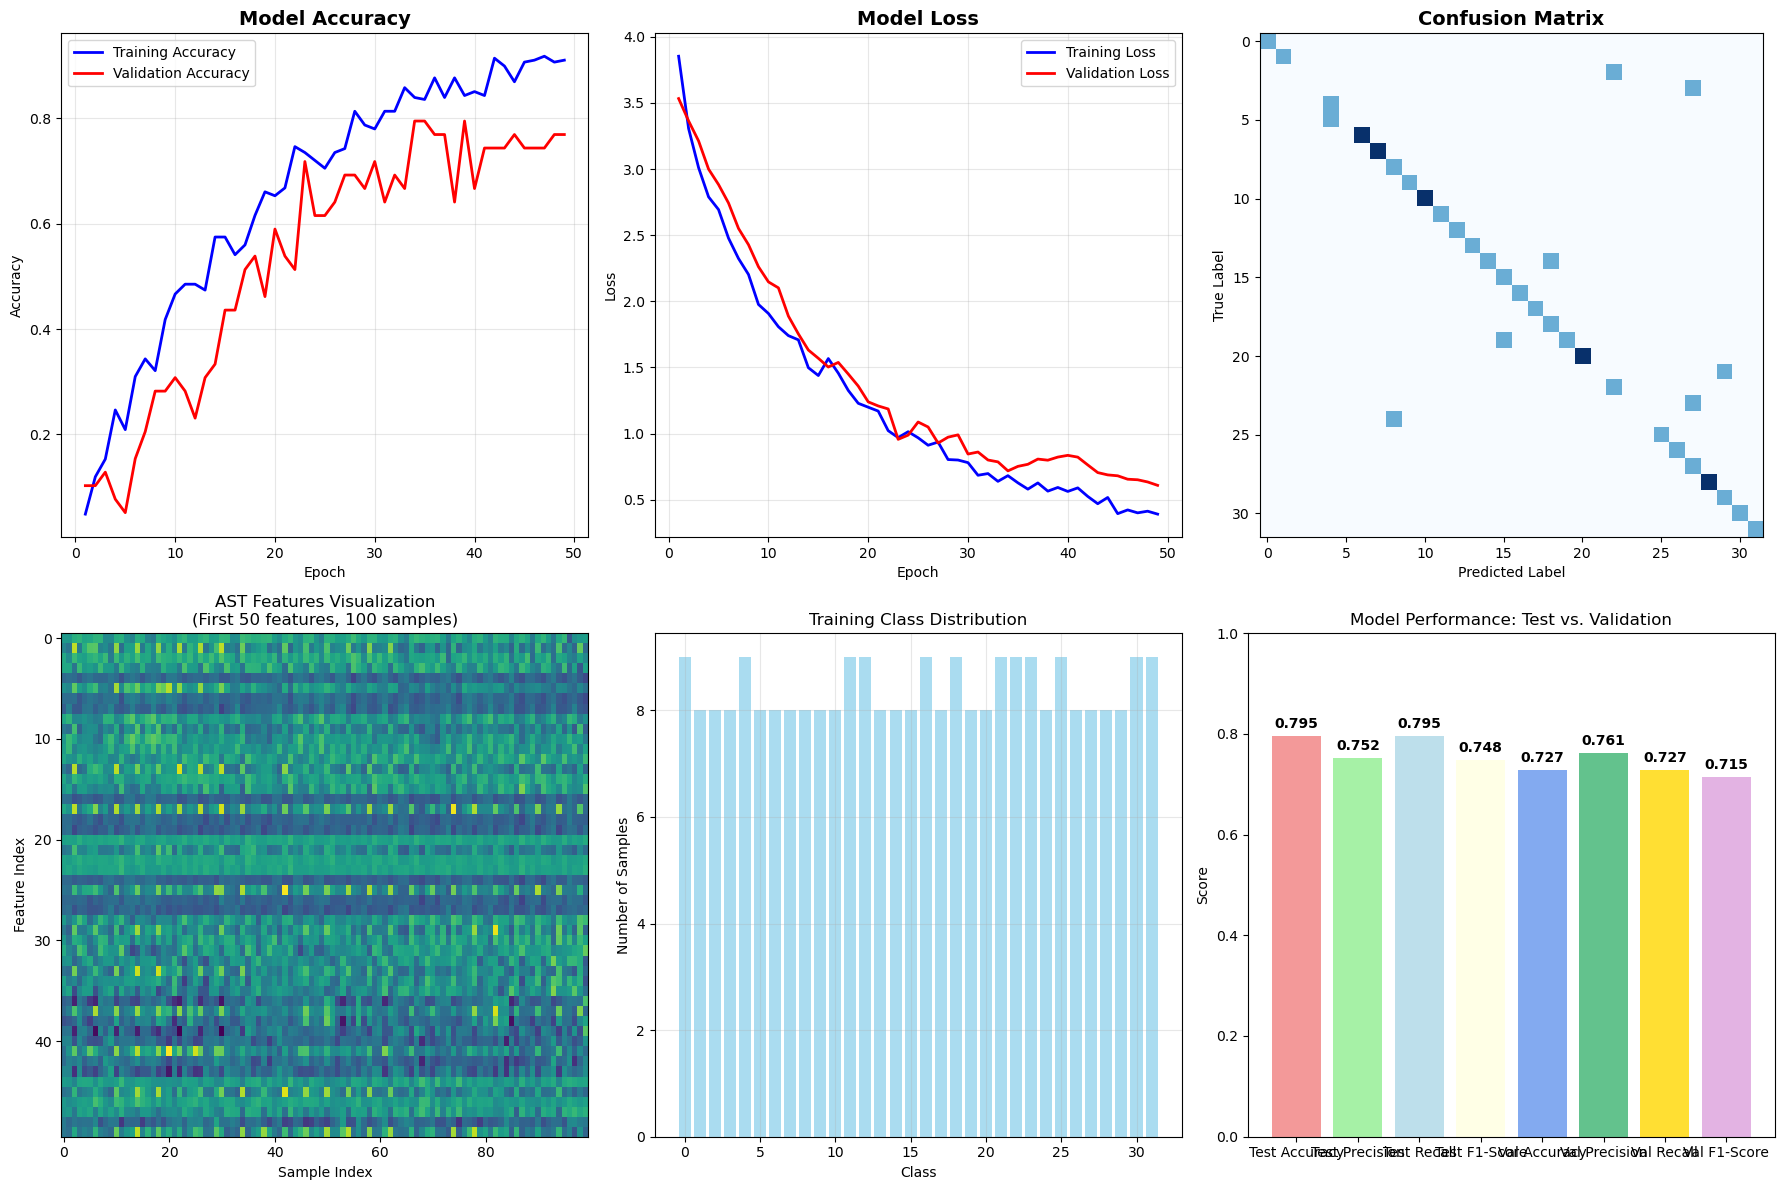


AST Features + Attention + FFNN Model Training Complete!
Final Test Accuracy: 79.49%
Validation Accuracy: 72.73%
Model saved and ready for use!


In [11]:
# Add these if not already computed (from previous code)
# values for validation set:
val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
    y_true_val, y_pred_val, average='weighted')

# Create comprehensive plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Training History - Accuracy
epochs_range = range(1, len(history.history['accuracy']) + 1)
axes[0, 0].plot(epochs_range, history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
axes[0, 0].plot(epochs_range, history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Training History - Loss
axes[0, 1].plot(epochs_range, history.history['loss'], 'b-', label='Training Loss', linewidth=2)
axes[0, 1].plot(epochs_range, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Confusion Matrix (test)
cm = confusion_matrix(y_true_test, y_pred_test)
im = axes[0, 2].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[0, 2].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Predicted Label')
axes[0, 2].set_ylabel('True Label')

# Plot 4: Feature Distribution (sample)
feature_sample = ast_features_scaled[:100, :50]  # First 50 features, 100 samples
im2 = axes[1, 0].imshow(feature_sample.T, cmap='viridis', aspect='auto')
axes[1, 0].set_title('AST Features Visualization\n(First 50 features, 100 samples)', fontsize=12)
axes[1, 0].set_xlabel('Sample Index')
axes[1, 0].set_ylabel('Feature Index')

# Plot 5: Class Distribution
class_counts = np.sum(y_train, axis=0)
axes[1, 1].bar(range(len(class_counts)), class_counts, color='skyblue', alpha=0.7)
axes[1, 1].set_title('Training Class Distribution', fontsize=12)
axes[1, 1].set_xlabel('Class')
axes[1, 1].set_ylabel('Number of Samples')
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Model Performance Summary (Test and Validation)
bar_labels = [
    'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1-Score',
    'Val Accuracy', 'Val Precision', 'Val Recall', 'Val F1-Score'
]
bar_values = [
    test_accuracy, precision_test, recall_test, f1_test,
    val_accuracy, val_precision, val_recall, val_f1
]
bar_colors = [
    'lightcoral', 'lightgreen', 'lightblue', 'lightyellow',
    'cornflowerblue', 'mediumseagreen', 'gold', 'plum'
]
bars = axes[1, 2].bar(bar_labels, bar_values, color=bar_colors, alpha=0.8)
axes[1, 2].set_title('Model Performance: Test vs. Validation', fontsize=12)
axes[1, 2].set_ylabel('Score')
axes[1, 2].set_ylim(0, 1)
for bar, value in zip(bars, bar_values):
    height = bar.get_height()
    axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nAST Features + Attention + FFNN Model Training Complete!")
print(f"Final Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Model saved and ready for use!")
